Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) $

if l2 norm append $\frac{\lambda}{2} \| w \|_2^2 $

if l1 norm append $\lambda \| w \|_1 $

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)}$

In [50]:
import numpy
# x: 1 by d
# w: d by 1
# y: scalar
# lam: scalar
# l1: boolean
# l2: boolean
def logistic_loss(x,w,y,lam,l1=False,l2=False):
    xw = numpy.dot(x,w) # scalar
    yxw = y * xw 
    error = numpy.log(1+numpy.exp(-yxw))
    if l2:
        norm = lam/2 * numpy.linalg.norm(w,ord=2) 
        error += norm 
    elif l1:
        norm = lam * numpy.linalg.norm(w,ord=1)
        error += norm
    return error[0,0]

In [22]:
# x: 1 by d
# w: d by 1
# y: scalar
# lam: scalar
# l1: boolean
# l2: boolean
def logistic_gradient(x,w,y,lam,l1=False,l2=False):
    yx = y * x
    yxw = numpy.dot(yx,w)
    denominator = 1 + numpy.exp(yxw)
    gradient = -1 * yx.T / denominator
    if l2:
        norm = 2 * lam * w
        gradient += norm
    elif l1:
        norm = lam * numpy.multiply(numpy.sign(w),w)
        gradient += norm
    return gradient

In [39]:
# X: n by d 
# y: n by 1
# lam: scalar
# stepsize: scalar
# max_epoch: scalar 
# w : d by 1
# gradient_function: 
# loss_function:
# proximal:
# l1: boolean
# l2: boolean
def saga(X,y,lam,stepsize,gradient_function,loss_function,proximal,max_epoch=100,w=None,l1=False,l2=False):
    n , d = X.shape
    if w == None:
        w = numpy.zeros((d,1))
        
    # initialize a table of gradients: n by d
    gradients = numpy.zeros((n,d))
    # fill in table with given weight
    for i in range(n):
        target = X[i].reshape((1,d))
        label = y[i]
        gradients[i] = gradient_function(target,w,label,lam,l1=l1,l2=l2).reshape(d)
        
    epoch_objs = []
        
    for epoch in range(max_epoch):
        # shuffle the entries
        perm = numpy.random.permutation(n)
        X_temp = X[perm] 
        y_temp = y[perm]
        
        obj_val = 0
        
        # for each epoch iterate through the set
        for i in range(n):
            target = X_temp[i].reshape((1,d))
            label = y_temp[i]
            gradient = gradient_function(target,w,label,lam,l1=l1,l2=l2)
            previous_gradient = gradients[perm[i]].reshape((d,1))
            gradients[perm[i]] = gradient.reshape(d)
            
            # update weight
            update = gradient - previous_gradient + numpy.mean(gradients,axis=0).reshape((d,1))
            w = w - stepsize * update
            w = proximal(w)
            
            # add the error
            obj_val += loss_function(target,w,label,lam,l1=l1,l2=l2)
            
        obj_val /= n
        print('Objective Value at epoch ' + str(epoch) + ' is ' + str(obj_val))
        epoch_objs.append(obj_val)
        
    return w,epoch_objs

In [40]:
import matplotlib.pyplot as plt

def graph(obj_vals,title,l1=False,l2=False):
    epochs = range(len(obj_vals))
    plt.plot(epochs, obj_vals)
    plt.xlabel('Epochs')
    plt.ylabel('Objective Value')
    if l1:
        title += ' L1 Norm'
    if l2: 
        title += ' L2 Norm'
    plt.title(title)
    plt.show()    

def graph_suboptimal(obj_vals,title,l1=False,l2=False,epochs=20):
    minimum = min(obj_vals)
    temp = obj_vals[:20] - minimum
    epochs = range(len(temp))
    plt.plot(epochs, temp)
    plt.xlabel('Epochs')
    plt.ylabel('Suboptimum')
    if l1:
        title += ' L1 Norm'
    if l2: 
        title += ' L2 Norm'
    plt.title(title)
    plt.show()

In [ ]:
# create new matrix with normalized rows
def normalize(matrix):
    ret = numpy.zeros(matrix.shape)
    for i in range(len(matrix)):
        vector = matrix[i]
        divisor = numpy.linalg.norm(vector)
        ret[i] = vector / divisor
    return ret

In [ ]:
# standardize by variance
def standardize(x_train,x_test):
    # calculate mu and sig using the training set
    d = x_train.shape[1]
    mu = numpy.mean(x_train, axis=0).reshape(1, d)
    sig = numpy.std(x_train, axis=0).reshape(1, d)

    # transform the training features
    x_train = (x_train - mu) / (sig + 1E-6)

    # transform the test features
    x_test = (x_test - mu) / (sig + 1E-6)

In [44]:
#https://gist.github.com/tylerneylon/ce60e8a06e7506ac45788443f7269e40
import struct

def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        array = numpy.frombuffer(f.read(), dtype=numpy.uint8).reshape(shape)
        return array.copy()

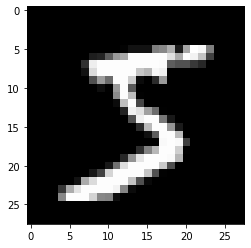

The testing label is 5


In [45]:
import matplotlib.pyplot as plt 

X_test = read_idx("mnist/t10k-images-idx3-ubyte")
y_test = read_idx("mnist/t10k-labels-idx1-ubyte")

X_train = read_idx("mnist/train-images-idx3-ubyte")
y_train = read_idx("mnist/train-labels-idx1-ubyte")


plt.imshow(X_train[0,:,:],cmap='gray')
plt.show()
print('The testing label is ' + str(y_train[0]))

y_train = numpy.array(list(map(lambda x:-1 if x < 5 else 1,y_train)))
y_test = numpy.array(list(map(lambda x:-1 if x <5 else 1, y_test)))


X_train = X_train[:1000,:,:]
y_train = y_train[:1000]
train_n,d,_ = X_train.shape
test_n,_,_ = X_test.shape

X_train = X_train.reshape((train_n,d*d))
X_test = X_test.reshape((test_n,d*d))


y_train = y_train.reshape((train_n,1))
y_test = y_test.reshape((test_n,1))

X_train = normalize(X_train)
X_test = normalize(X_test)

In [54]:
proximal = lambda x: x
_,eigs,_ = numpy.linalg.svd(numpy.dot(X_train,X_train.T))
L = 1/4 * eigs[0]
n,d = numpy.shape(X_train)
alpha = 1E-6
step_size = 1 / (n * alpha + L)
w, obj_vals = saga(X_train,y_train,alpha,step_size,logistic_gradient,logistic_loss, proximal,l1=True,max_epoch=1000)

Objective Value at epoch 0 is 0.6793341953911012
Objective Value at epoch 1 is 0.6539089918588682
Objective Value at epoch 2 is 0.6332098048195541
Objective Value at epoch 3 is 0.6143825429767971
Objective Value at epoch 4 is 0.5990985587129019
Objective Value at epoch 5 is 0.585312081073896
Objective Value at epoch 6 is 0.5733376042021472
Objective Value at epoch 7 is 0.5623697530584482
Objective Value at epoch 8 is 0.5527152884646301
Objective Value at epoch 9 is 0.5443595988318681
Objective Value at epoch 10 is 0.5363558601340691
Objective Value at epoch 11 is 0.5292242168465112
Objective Value at epoch 12 is 0.5223793155057761
Objective Value at epoch 13 is 0.5162779277465817
Objective Value at epoch 14 is 0.5104331294164826
Objective Value at epoch 15 is 0.5050204357021895
Objective Value at epoch 16 is 0.5000319063643428
Objective Value at epoch 17 is 0.4952616492246849
Objective Value at epoch 18 is 0.49074374920982455
Objective Value at epoch 19 is 0.4866645541987464
Objective 

Objective Value at epoch 162 is 0.3452630385821579
Objective Value at epoch 163 is 0.3449493076981024
Objective Value at epoch 164 is 0.3446367499286332
Objective Value at epoch 165 is 0.34433464520068263
Objective Value at epoch 166 is 0.344017920335151
Objective Value at epoch 167 is 0.34370409971382904
Objective Value at epoch 168 is 0.34339857457893197
Objective Value at epoch 169 is 0.3431024687483433
Objective Value at epoch 170 is 0.3427951565289991
Objective Value at epoch 171 is 0.3425000251777285
Objective Value at epoch 172 is 0.3422059874376791
Objective Value at epoch 173 is 0.34192231634557857
Objective Value at epoch 174 is 0.341617874125182
Objective Value at epoch 175 is 0.3413301415230027
Objective Value at epoch 176 is 0.34103675581339266
Objective Value at epoch 177 is 0.34075529424372347
Objective Value at epoch 178 is 0.3404724657843041
Objective Value at epoch 179 is 0.34019818050262723
Objective Value at epoch 180 is 0.33990496547057897
Objective Value at epoch 

Objective Value at epoch 322 is 0.3109681977866657
Objective Value at epoch 323 is 0.31081745436403085
Objective Value at epoch 324 is 0.3106650778684262
Objective Value at epoch 325 is 0.31051482227053867
Objective Value at epoch 326 is 0.3103627928545483
Objective Value at epoch 327 is 0.3102112790817683
Objective Value at epoch 328 is 0.310062980571077
Objective Value at epoch 329 is 0.3099066110365336
Objective Value at epoch 330 is 0.3097533862428252
Objective Value at epoch 331 is 0.309610356129498
Objective Value at epoch 332 is 0.3094588488652746
Objective Value at epoch 333 is 0.309310676032659
Objective Value at epoch 334 is 0.30916181108099317
Objective Value at epoch 335 is 0.3090114397577764
Objective Value at epoch 336 is 0.3088615560367927
Objective Value at epoch 337 is 0.30872069615433734
Objective Value at epoch 338 is 0.30856771744468703
Objective Value at epoch 339 is 0.3084210364015685
Objective Value at epoch 340 is 0.30827711419425263
Objective Value at epoch 341

Objective Value at epoch 482 is 0.2908488460392904
Objective Value at epoch 483 is 0.2907470179157752
Objective Value at epoch 484 is 0.29064472266620284
Objective Value at epoch 485 is 0.29054025029303504
Objective Value at epoch 486 is 0.2904372819221421
Objective Value at epoch 487 is 0.2903279056754013
Objective Value at epoch 488 is 0.29022606114911487
Objective Value at epoch 489 is 0.29012417769787313
Objective Value at epoch 490 is 0.2900223855166432
Objective Value at epoch 491 is 0.28991966525495255
Objective Value at epoch 492 is 0.28981635013881435
Objective Value at epoch 493 is 0.28971862916849794
Objective Value at epoch 494 is 0.2896110216663067
Objective Value at epoch 495 is 0.2895093596597963
Objective Value at epoch 496 is 0.28940824215115235
Objective Value at epoch 497 is 0.2893042293637696
Objective Value at epoch 498 is 0.28920681180229274
Objective Value at epoch 499 is 0.28910288344021184
Objective Value at epoch 500 is 0.2890068718698862
Objective Value at ep

Objective Value at epoch 642 is 0.2763190516691643
Objective Value at epoch 643 is 0.27624235517341583
Objective Value at epoch 644 is 0.2761611655086814
Objective Value at epoch 645 is 0.276081720397313
Objective Value at epoch 646 is 0.27600257600009853
Objective Value at epoch 647 is 0.275923602357715
Objective Value at epoch 648 is 0.27584605629781417
Objective Value at epoch 649 is 0.27576760508296444
Objective Value at epoch 650 is 0.27568951035882744
Objective Value at epoch 651 is 0.2756103267267968
Objective Value at epoch 652 is 0.2755328777743573
Objective Value at epoch 653 is 0.27545318386417567
Objective Value at epoch 654 is 0.27537522843838375
Objective Value at epoch 655 is 0.2752950162219694
Objective Value at epoch 656 is 0.2752157409556452
Objective Value at epoch 657 is 0.2751416724301369
Objective Value at epoch 658 is 0.275063697499387
Objective Value at epoch 659 is 0.27498313477424335
Objective Value at epoch 660 is 0.2749088365927675
Objective Value at epoch 6

Objective Value at epoch 802 is 0.26491762781690525
Objective Value at epoch 803 is 0.264855785555205
Objective Value at epoch 804 is 0.26478879752424483
Objective Value at epoch 805 is 0.2647253262891334
Objective Value at epoch 806 is 0.2646618396382822
Objective Value at epoch 807 is 0.26459562268986137
Objective Value at epoch 808 is 0.26453280900232395
Objective Value at epoch 809 is 0.26447177481380324
Objective Value at epoch 810 is 0.26440426237058967
Objective Value at epoch 811 is 0.26434242991257023
Objective Value at epoch 812 is 0.26427793330712074
Objective Value at epoch 813 is 0.26421456060865023
Objective Value at epoch 814 is 0.2641517991213513
Objective Value at epoch 815 is 0.2640890519979422
Objective Value at epoch 816 is 0.2640256316908888
Objective Value at epoch 817 is 0.26396327372855866
Objective Value at epoch 818 is 0.2638986553154085
Objective Value at epoch 819 is 0.2638366295077524
Objective Value at epoch 820 is 0.2637736897576198
Objective Value at epo

Objective Value at epoch 962 is 0.25553446263641966
Objective Value at epoch 963 is 0.2554814062532052
Objective Value at epoch 964 is 0.2554260611468683
Objective Value at epoch 965 is 0.2553740478928542
Objective Value at epoch 966 is 0.25531974333026236
Objective Value at epoch 967 is 0.25526555393514067
Objective Value at epoch 968 is 0.2552113476807236
Objective Value at epoch 969 is 0.2551595049429016
Objective Value at epoch 970 is 0.25510587712839466
Objective Value at epoch 971 is 0.2550530086599428
Objective Value at epoch 972 is 0.2550003171467598
Objective Value at epoch 973 is 0.25494607086161575
Objective Value at epoch 974 is 0.2548932882331573
Objective Value at epoch 975 is 0.25483956770308974
Objective Value at epoch 976 is 0.2547873826289942
Objective Value at epoch 977 is 0.2547340478565574
Objective Value at epoch 978 is 0.25468084561115334
Objective Value at epoch 979 is 0.25462994500582264
Objective Value at epoch 980 is 0.25457653519995976
Objective Value at epo

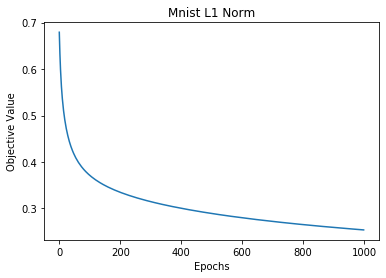

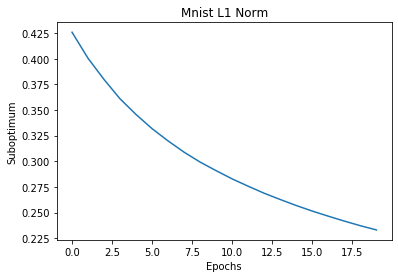

In [55]:
graph(obj_vals,'Mnist',l1=True)
graph_suboptimal(obj_vals,'Mnist',l1=True)